In [1]:
# Appeding the path to the scaman package
import sys
sys.path.append('/Users/berke/Codes/scaman/scaman')

In [2]:
import random
import numpy as np
from utils.intrinsic_dimension_estimator import Estimator
from sklearn.datasets import make_low_rank_matrix

In [3]:
# Step 1: Generate toy data matrix
#X = np.random.randn(5000, 500)
X = make_low_rank_matrix(500, 50, effective_rank=12,
                         tail_strength=0.05, random_state=123)  # random state for reproducibility
X = np.asarray(X)


In [24]:
labels = np.random.randint(0, 2, size=500)

In [4]:
# Step 2: Center data matrix
means = np.mean(X, axis=0)
X_centered = X - means

In [5]:
# Step 3: Verify that covariance matrix is centered
assert np.allclose(np.mean(X_centered, axis=0), np.zeros_like(means))

In [6]:
# Step 4: Compute covariance matrix
cov = np.cov(X, rowvar=False)
eigs = np.linalg.eig(cov)[0]
eigs_sorted = np.flip(np.sort(eigs))
variances = np.cumsum(eigs_sorted)/np.sum(eigs_sorted)
tv = 0.8
actual_dim = np.argmax(np.array(variances)>tv)
print(eigs_sorted)

[2.00217861e-03 1.97470443e-03 1.89559836e-03 1.77351154e-03
 1.61715460e-03 1.43374900e-03 1.24032724e-03 1.03297340e-03
 8.62106255e-04 6.91373787e-04 5.40983000e-04 4.15722707e-04
 3.06368033e-04 2.28091025e-04 1.66147362e-04 1.18251854e-04
 8.35183567e-05 5.86382560e-05 4.10440329e-05 2.86209516e-05
 2.05345226e-05 1.49443450e-05 1.11470385e-05 8.52737164e-06
 6.81856864e-06 5.60370293e-06 4.80089136e-06 4.22705988e-06
 3.82323757e-06 3.53024644e-06 3.30684437e-06 3.16978373e-06
 3.05791277e-06 2.96431231e-06 2.88971591e-06 2.82439427e-06
 2.76233542e-06 2.71411551e-06 2.66450571e-06 2.58979558e-06
 2.57425520e-06 2.52825763e-06 2.48488845e-06 2.44595874e-06
 2.40152073e-06 2.35709835e-06 2.32650004e-06 2.28653915e-06
 2.21515349e-06 2.19329669e-06]


In [7]:
# Step 5: Create Estimator instance
estimator = Estimator(X_centered, p=20, nk=8, epsilon=0.1, delta=0.1, tv = tv)
#print(estimator.eigenvalueCountEstimator(X_centered,70,0.1,0.1,0.00016,0.00019,eigs_sorted[49]*0.9,eigs_sorted[0]*1.1))
estDim, estVar, estDimF = estimator.estimator()
print(f"Actual Dim = {actual_dim}, Estimated Dim = {estDim}, Estimated Var = {estVar}, Estimated Final Dim = {estDimF}")

Actual Dim = 8, Estimated Dim = 9, Estimated Var = 0.9118663265023057, Estimated Final Dim = 11


Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2
Solution method: krylovschur
Number of requested eigenvalues: 9
Stopping condition: tol=1e-09, maxit=10000
Number of converged eigenpairs 12

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
    -0.000000           7.34078
     0.998681       2.09343e-11
     0.998815       7.70102e-11
     0.998952       8.99092e-10
     0.999111       1.29993e-15
     0.999225       3.04916e-15
     0.999724       1.41399e-15
     1.000099       1.81596e-13
     1.000313       7.72466e-14
     1.000582        3.0687e-13
     1.000920         8.774e-12
     1.001113       3.77983e-10



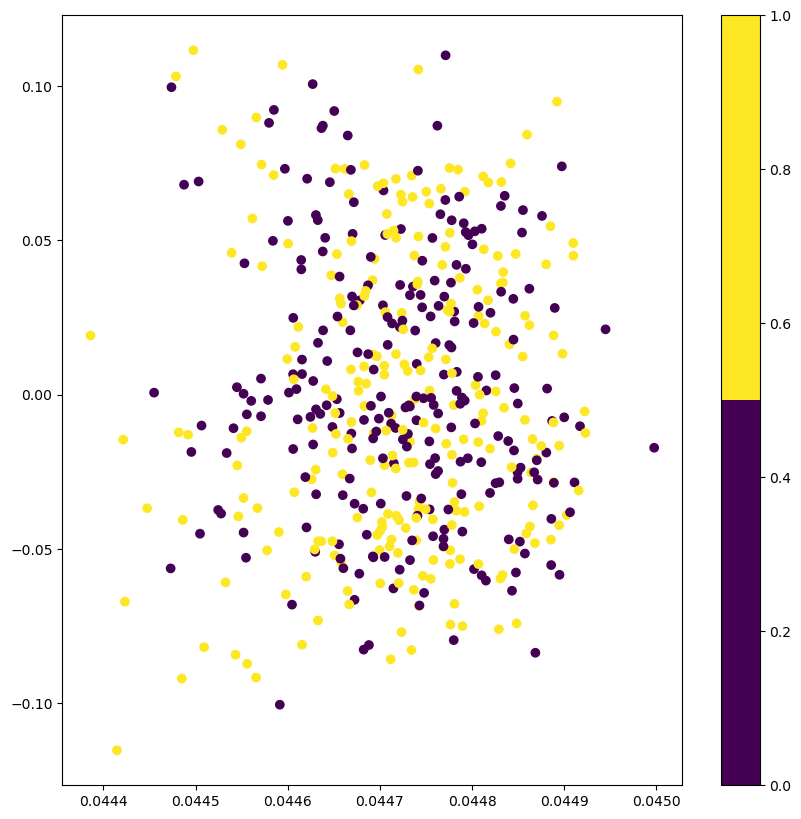

Embedding shape = (500, 10)


In [40]:
## Creating test with slepc solver with estimated dimension
# Create an instance of the LE class
from serial.le import LE
le = LE(X, n_components=estDim, k=100, solver='slepc',slepc_solver='KRYLOVSCHUR',sigma= 1,normalize=True)
embedding_le = le.fit_transform()
le.plot_2d(embedding_le)
print(f"Embedding shape = {embedding_le.shape}")



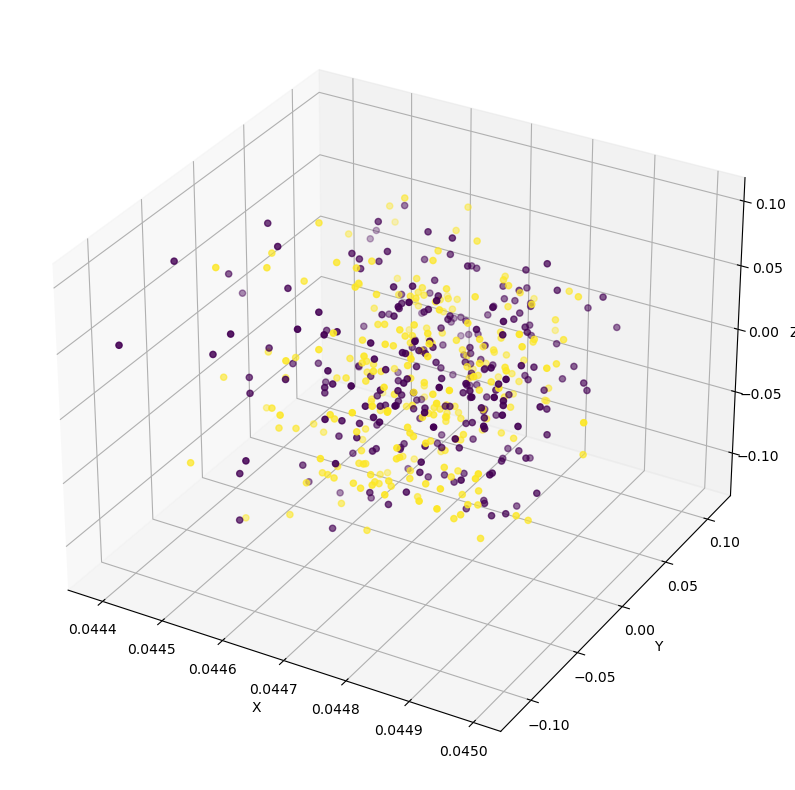

In [41]:
le.plot_3d(embedding_le, labels=labels)

Petsc matrix formed

******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 1
Solution method: krylovschur
Number of requested eigenvalues: 9
Stopping condition: tol=0.01, maxit=1000
Number of converged eigenpairs 19

Eigenpairs:
        k          ||Ax-kx||/||kx|| 
----------------- ------------------
     0.002002       9.01665e-16
     0.001975         7.694e-16
     0.001896       5.56478e-16
     0.001774       8.49449e-16
     0.001617       7.51984e-16
     0.001434        6.1125e-15
     0.001240       5.52661e-15
     0.001033       2.62132e-13
     0.000862       4.16297e-13
     0.000691        3.2135e-12
     0.000541       2.98779e-11
     0.000416       4.91244e-10
     0.000306       2.54411e-07
     0.000228        2.0904e-07
     0.000166       1.47265e-05
     0.000118       7.78735e-05
     0.000084        0.00028135
     0.000059        0.00980537
     0.000041        0.00889932

Time taken t

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


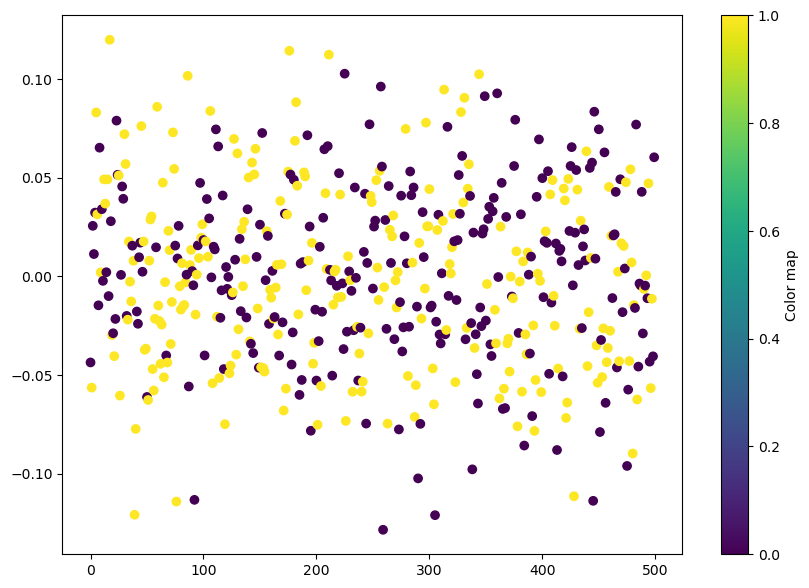

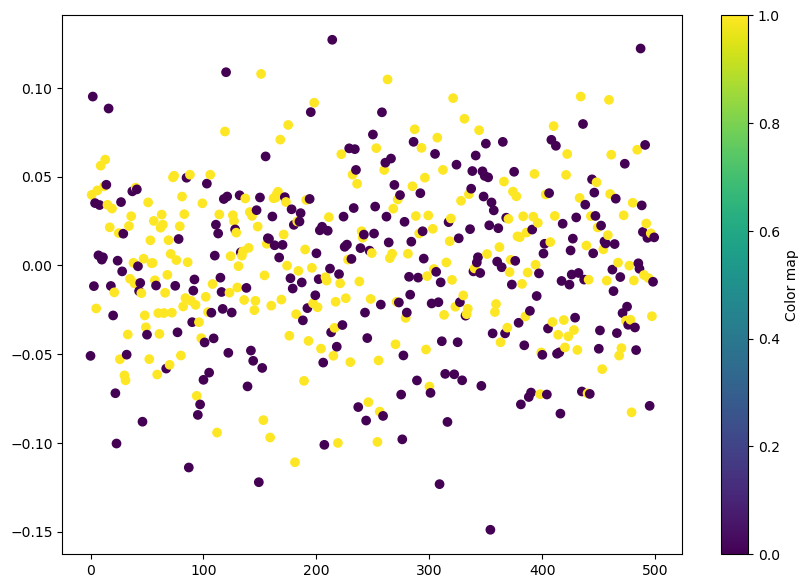

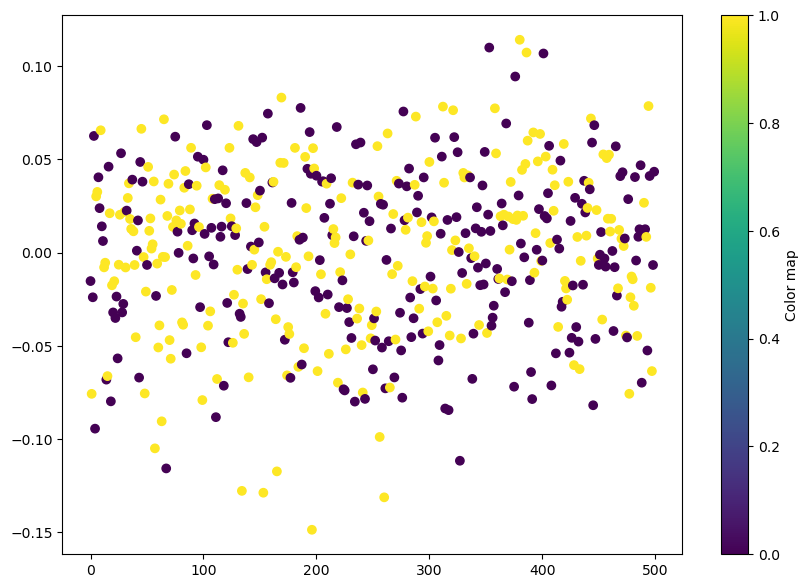

In [47]:
## Created test with estimated dimension and PCA
from serial.pca import PCA
pca = PCA(n_components=estDim,eig_method='slepc',tol=0.01,max_it=1000)
embedding_pca = pca.fit_transform(X)
#plot the embedding with the first two components
embedding_pca = np.real(embedding_pca)
pca.plot(embedding_pca, color=labels)

